# Modelling

Two different models are assessed to understand how well they could predict weekly sales distribution. XGBoost is selected as the baseline model. The other 2 algorithms are ARIMA and Neural Networks.

This script prepares the data for modelling and can be used to run ARIMA and Neural Netowrk for weekly sales forcast. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import glob
import json

import xgboost as xgb

import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler, LabelEncoder
from pmdarima import auto_arima
from scipy.stats import pearsonr
from statsmodels.tsa.stattools import adfuller

In [2]:
# set variables from config file
config_path = os.path.abspath('..')

with open(config_path + '\config-example.json', 'r') as f:
    config = json.load(f)

dataset_EDA_fname = config['DEFAULT']['dataset_EDA_fname']
processing_path = config['DEFAULT']['processing_path']
dataset_fname_suffix = config['DEFAULT']['dataset_fname_suffix']

In [37]:
client_data = pd.read_csv(os.path.join(processing_path,dataset_EDA_fname) + dataset_fname_suffix, header = 0, delimiter = ',')

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_13768\1981297199.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  client_data = pd.read_csv(os.path.join(processing_path,dataset_EDA_fname) + dataset_fname_suffix, header = 0, delimiter = ',')


In [38]:
client_data['StartDate'] = pd.to_datetime(client_data['StartDate'], infer_datetime_format=True)
client_data['StatusCreatedDate'] = pd.to_datetime(client_data['StatusCreatedDate'], infer_datetime_format=True)

# ARIMA Model
Use an ARIMA model to predict weekly sales Consider 30 percent of
data for testing. 

C:\Users\KingRemy\AppData\Local\Temp\ipykernel_13768\2466224165.py:6: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  arima_client_data['Max_Week'] = arima_client_data['Max_Purchase_Week_Date'].dt.week
C:\Users\KingRemy\AppData\Local\Temp\ipykernel_13768\2466224165.py:7: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  arima_client_data['Min_Week'] = arima_client_data['Min_Purchase_Week_Date'].dt.week


<Axes: title={'center': 'Average weekly ticket purhcase per event'}, xlabel='Event Dates', ylabel='Number of bookings'>

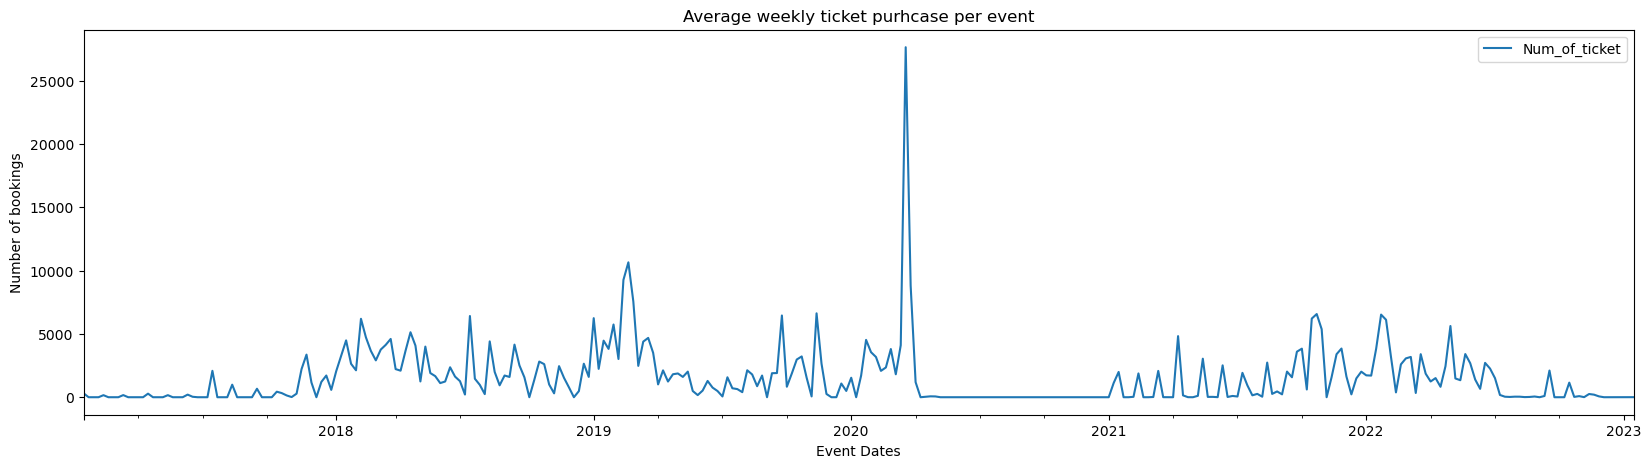

In [48]:
arima_client_data = client_data.groupby(['StatusCreatedDate'], as_index=False).agg(
                                                                                            Min_Purchase_Week_Date = pd.NamedAgg(column='StatusCreatedDate', aggfunc='min'),
                                                                                            Max_Purchase_Week_Date = pd.NamedAgg(column='StatusCreatedDate', aggfunc='max'),  
                                                                                            Num_of_ticket = pd.NamedAgg(column='BookingReference', aggfunc='count')
                                                                                            )
arima_client_data['Max_Week'] = arima_client_data['Max_Purchase_Week_Date'].dt.week
arima_client_data['Min_Week'] = arima_client_data['Min_Purchase_Week_Date'].dt.week

# Set the StartDate as index
arima_client_data = arima_client_data.set_index('StatusCreatedDate')

arima_client_data = arima_client_data.groupby([pd.Grouper(level='StatusCreatedDate', freq='W')]).sum()

#dropping rows with Null values
arima_client_data.dropna(inplace=True)

arima_client_data['Num_of_ticket'].plot(legend=True, figsize=(20,5), xlabel = 'Booking Dates', ylabel='Number of bookings', title='Weekly ticket sales for events')       

<Axes: title={'center': 'Weekly ticket sales'}, xlabel='Booking Dates', ylabel='Number of bookings'>

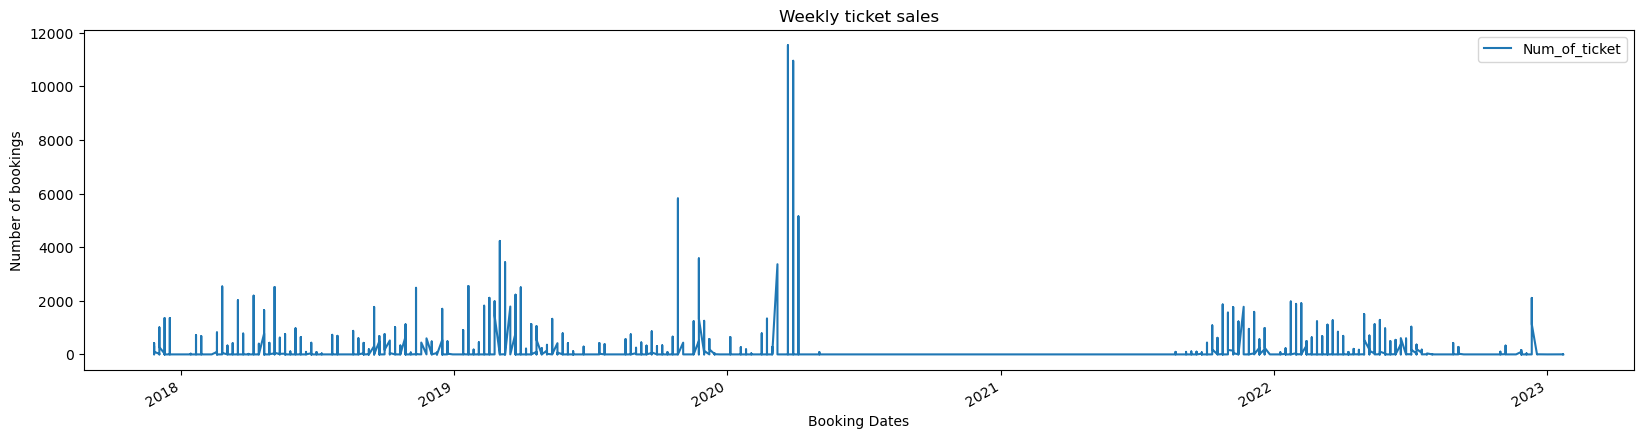

In [45]:
arima_client_data['Num_of_ticket'].plot(legend=True, figsize=(20,5), xlabel = 'Booking Dates', ylabel='Number of bookings', title='Weekly ticket sales')

### Normalizing the Dataset

The different features in the dataset are on diffeberent scales of values. It's always best practice to scale all features to be on the same range of values so as to help the machine learning algorithm do better during training. Here, we use the `StandardScaler` to normalize all features to have values between -1 and +1.

In [27]:
cols_to_normalize = ['Max_Week', 'Min_Week', 'Num_of_ticket']

# Instantiate the standard scaler
sc = StandardScaler()

for col in cols_to_normalize:
    arima_client_data[col] = sc.fit_transform(arima_client_data[[col]])

Use an ARIMA model to predict the weekly sales (Number of tickets). Consider 30 percent of data for testing. 

In [28]:
# Check if dataset is stationary
def ad_test(dataset):
     dftest = adfuller(dataset, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression:",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)
ad_test(arima_client_data['Num_of_ticket'])

1. ADF :  -5.464868692748513
2. P-Value :  2.4717286252335418e-06
3. Num Of Lags :  1
4. Num Of Observations Used For ADF Regression: 160
5. Critical Values :
	 1% :  -3.4718957209472654
	 5% :  -2.8797795410156253
	 10% :  -2.5764947265625


In [30]:
# using auto arima to predict best p, d, q values
stepwise_fit = auto_arima(arima_client_data['Num_of_ticket'], trace=True,
                         suppress_warnings=True)
stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=498.615, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=455.274, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=445.655, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=496.628, Time=0.03 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.67 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=443.615, Time=0.19 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.98 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.82 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=442.052, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=443.778, Time=0.11 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=436.159, Time=0.47 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=438.902, Time=0.35 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=434.751, Time=0.60 sec
 A

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  162
Model:               SARIMAX(2, 1, 1)   Log Likelihood                -212.377
Date:                Sat, 25 Mar 2023   AIC                            432.753
Time:                        12:00:36   BIC                            445.079
Sample:                             0   HQIC                           437.758
                                - 162                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2430      0.089      2.736      0.006       0.069       0.417
ar.L2          0.2329      0.078      2.982      0.003       0.080       0.386
ma.L1         -0.9664      0.045    -21.432      0.000      -1.055      -0.878
sigma2         0.8103      0.036     22.470      0.000       0.740       0.881
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              1764.53
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               0.20   Skew:                             2.66
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
# Split dataset 
split_size = int(0.7*len(arima_client_data))

train_client_data = arima_client_data.iloc[:split_size, :]
test_client_data = arima_client_data.iloc[split_size:, :]

In [33]:
# Fit ARIMA model on best p, d, q values
model = sm.tsa.arima.ARIMA(train_client_data["Num_of_ticket"], order=(2,1,1))
arima_model = model.fit()
arima_model.summary()

c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          Num_of_ticket   No. Observations:                  113
Model:                 ARIMA(2, 1, 1)   Log Likelihood                -172.302
Date:                Sat, 25 Mar 2023   AIC                            352.605
Time:                        12:01:24   BIC                            363.479
Sample:                             0   HQIC                           357.017
                                - 113                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6313      0.473     -1.333      0.182      -1.559       0.297
ar.L2         -0.1956      0.222     -0.883      0.377      -0.630       0.239
ma.L1          0.0548      0.501      0.109      0.913      -0.927       1.036
sigma2         1.2661      0.090     14.027      0.000       1.089       1.443
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               344.86
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               1.82   Skew:                             1.38
Prob(H) (two-sided):                  0.07   Kurtosis:                        11.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

c:\Users\KingRemy\anaconda3\envs\elec\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


<Axes: xlabel='StartDate', ylabel='Average ticket booking'>

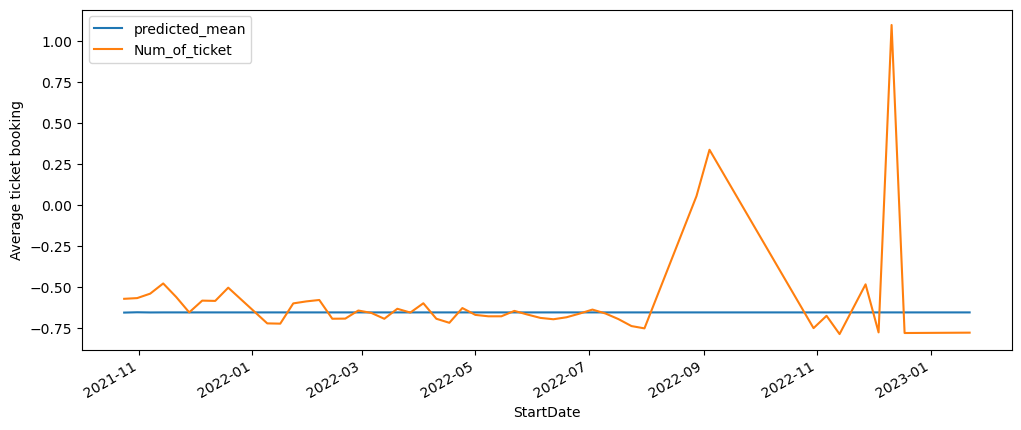

In [34]:
start_index = len(train_client_data)
stop_index = len(train_client_data) + len(test_client_data)-1

# prediction on test length
pred = arima_model.predict(start=start_index, end=stop_index)
pred.index=arima_client_data.index[start_index:stop_index+1]
# print(pred)

pred.plot(legend=True, figsize=(20,10), xlabel = 'Week', ylabel='Average ticket booking' )
test_client_data['Num_of_ticket'].plot(legend=True, figsize=(12,5))


In [35]:
arima_client_data['Num_of_ticket'].mean()

-5.619647408596472e-17

In [36]:
mse = mean_squared_error(test_client_data["Num_of_ticket"], pred)

print(f"Mean Squared Error for ARIMA model is {round(mse, 3)}")

# print("prediction on weekly average of demand rate")
# pred[:6]

Mean Squared Error for ARIMA model is 0.098
